# Prepare data

## Donwload images

In [91]:
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

## Decompress zip file

In [92]:
from zipfile import ZipFile
import os
file_name='./chest-xray-pneumonia.zip'
files_local_location='./images'
chest_xray_dir = f"{files_local_location}/chest_xray"

if not os.path.exists(chest_xray_dir):
    with ZipFile(file_name,'r') as zip:
        zip.extractall(path=files_local_location)
        print('The file has been decompressed')

## Delete repeated and unused folders

In [93]:
import shutil
from tqdm import tqdm

paths_to_delete = [ f'{chest_xray_dir}/__MACOSX/',
                    f'{chest_xray_dir}/chest_xray/']

for folder_path in tqdm(paths_to_delete):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"'{folder_path}' has been deleted deleted")
    else:
        print(f"'{folder_path}' doesn't exists")

100%|██████████| 2/2 [00:00<00:00, 2001.10it/s]

'./images/chest_xray/__MACOSX/' doesn't exists
'./images/chest_xray/chest_xray/' doesn't exists


# Setting the initial folder directories location

In [94]:
train_directory = f'{chest_xray_dir}/train'
test_directory = f'{chest_xray_dir}/test'
validation_directory = f'{chest_xray_dir}/val'

## Preparing some data

In [95]:
from config.ClassificationNames import ClassificationNames

classification_names = list(map(lambda item: item.name, ClassificationNames.to_array()))

['NORMAL', 'PNEUMONIA']

# Hands on

In [96]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Rescaling, \
                                    Resizing, RandomRotation, RandomZoom, RandomContrast, ReLU
from tensorflow.keras.models import Sequential
from keras import regularizers

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

import cv2

import glob


In [97]:
pneumonia_train_images = glob.glob(f"{train_directory}/PNEUMONIA/*")
normal_train_images = glob.glob(f"{train_directory}/NORMAL/*")
pneumonia_test_images = glob.glob(f"{test_directory}/PNEUMONIA/*")
normal_test_images = glob.glob(f"{test_directory}/NORMAL/*")
pneumonia_validation_images = glob.glob(f"{validation_directory}/PNEUMONIA/*")
normal_validation_images = glob.glob(f"{validation_directory}/NORMAL/*")

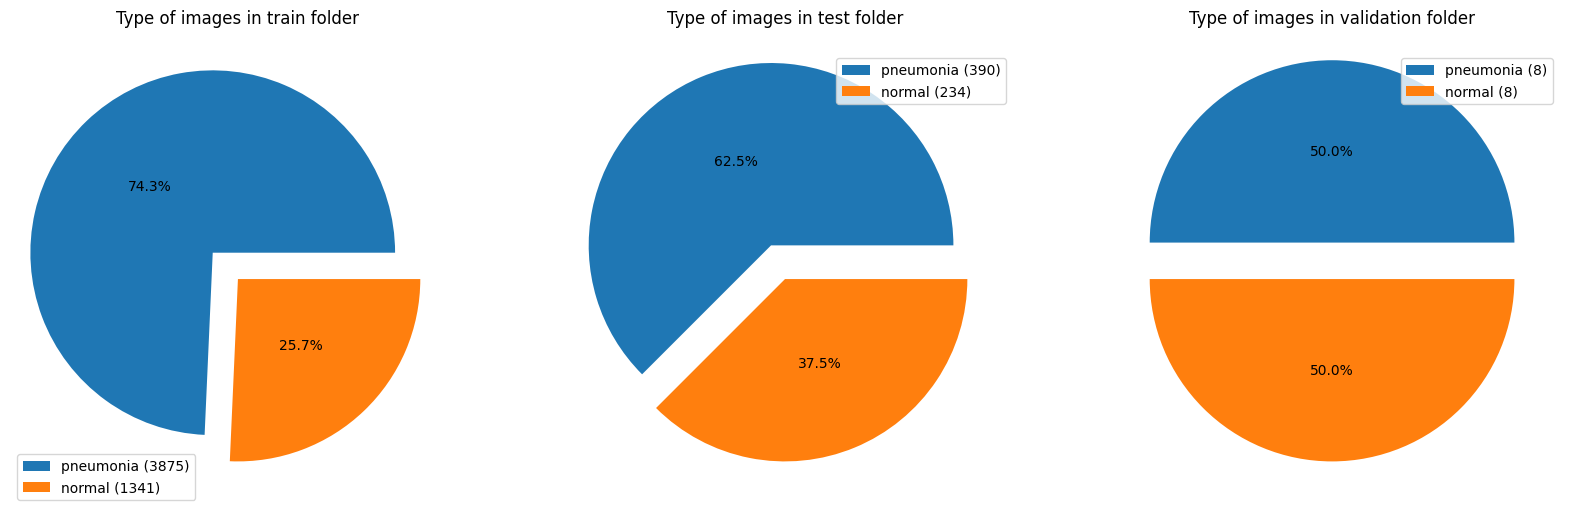

In [98]:
fig, (first_ax, middle_ax, last_ax) = plt.subplots(1, 3)

fig.set_size_inches(20,15)
first_ax.pie(x=np.array([len(pneumonia_train_images), len(normal_train_images)]),
                autopct="%.1f%%",
                explode=[0.2,0],
                pctdistance=0.5)
first_ax.set_title("Type of images in train folder", pad=20)
first_ax.legend([f"pneumonia ({len(pneumonia_train_images)})", f"normal ({len(normal_train_images)})"])

middle_ax.pie(x=np.array([len(pneumonia_test_images), len(normal_test_images)]),
                autopct="%.1f%%",
                explode=[0.2,0],
                pctdistance=0.5)
middle_ax.set_title("Type of images in test folder", pad=20)
middle_ax.legend([f"pneumonia ({len(pneumonia_test_images)})", f"normal ({len(normal_test_images)})"])

last_ax.pie(x=np.array([len(pneumonia_validation_images), len(normal_validation_images)]),
            autopct="%.1f%%",
            explode=[0.2,0],
            pctdistance=0.5)
last_ax.set_title("Type of images in validation folder", pad=20)
last_ax.legend([f"pneumonia ({len(pneumonia_validation_images)})", f"normal ({len(normal_validation_images)})"])

plt.show()


In [99]:
image_size = (220, 220)
batch_size = 20

train_dataset = image_dataset_from_directory(directory=train_directory,
                                                labels='inferred',
                                                label_mode='binary',
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                image_size=image_size,
                                                shuffle=True
                                                )
validation_dataset = image_dataset_from_directory(directory=validation_directory,
                                                labels='inferred',
                                                label_mode='binary',
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                image_size=image_size,
                                                shuffle=True
                                                )
test_dataset = image_dataset_from_directory(directory=test_directory,
                                                labels='inferred',
                                                label_mode='binary',
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                image_size=image_size,
                                                shuffle=False
                                                )


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [122]:
len(list(validation_dataset.))

1

## Feature Extraction

In [100]:
input_shape = (220, 220, 3)
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False
base_model.summary()


Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 226, 226, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 110, 110, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [101]:
model = Sequential()
model.add(base_model)
model.add(Rescaling(1./255))
model.add(RandomRotation(0.4))
model.add(RandomZoom(0.2))
model.add(ReLU())
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = 'relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 rescaling (Rescaling)       (None, 7, 7, 2048)        0         
                                                                 
 random_rotation (RandomRota  (None, 7, 7, 2048)       0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 7, 7, 2048)        0         
                                                                 
 re_lu (ReLU)                (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                 

In [102]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])
history = model.fit(train_dataset,
                    steps_per_epoch = len(train_dataset),
                    epochs=30,
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset))

Epoch 1/30


c:\Users\jamua\.conda\envs\pneumonia-classification\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/random_rotation/loop_body/GatherV2/pfor/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/random_rotation/loop_body/GatherV2/pfor/Reshape:0", shape=(None, 7, 7, 2048), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/random_rotation/loop_body/GatherV2/pfor/Cast:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


261/261 [==============================] - 147s 542ms/step - loss: 0.6691 - accuracy: 0.8043 - val_loss: 0.5646 - val_accuracy: 0.8301
Epoch 2/30
261/261 [==============================] - 142s 542ms/step - loss: 0.4289 - accuracy: 0.8731 - val_loss: 0.4807 - val_accuracy: 0.8526
Epoch 3/30
261/261 [==============================] - 147s 563ms/step - loss: 0.3661 - accuracy: 0.8936 - val_loss: 0.6269 - val_accuracy: 0.7997
Epoch 4/30
261/261 [==============================] - 149s 572ms/step - loss: 0.3771 - accuracy: 0.8712 - val_loss: 0.5567 - val_accuracy: 0.8237
Epoch 5/30
261/261 [==============================] - 151s 579ms/step - loss: 0.3438 - accuracy: 0.8840 - val_loss: 0.4414 - val_accuracy: 0.8638
Epoch 6/30
261/261 [==============================] - 149s 570ms/step - loss: 0.3288 - accuracy: 0.8838 - val_loss: 0.4250 - val_accuracy: 0.8558
Epoch 7/30
261/261 [==============================] - 147s 561ms/step - loss: 0.3249 - accuracy: 0.8859 - val_loss: 0.4563 - val_accura

In [103]:
model.save("model.h5")

In [104]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

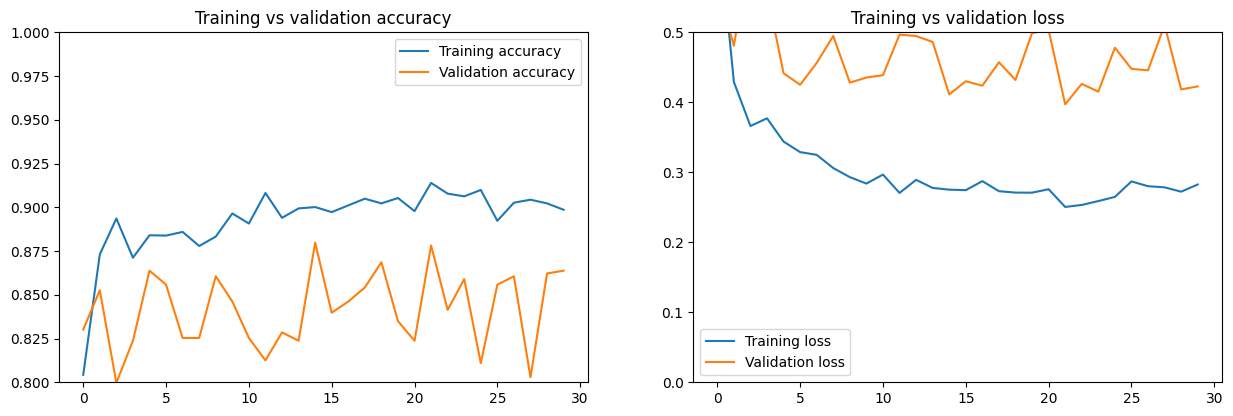

In [105]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.ylim(0.8, 1)
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.ylim(0, 0.5)
plt.legend()
plt.title("Training vs validation loss")

plt.show()


In [106]:
pred = model.predict(validation_dataset)
pred


1/1 [==============================] - 1s 1s/step


array([[0.9480411 ],
       [0.9690963 ],
       [0.24463516],
       [0.9903317 ],
       [0.84300274],
       [0.9994778 ],
       [0.95226073],
       [0.9599208 ],
       [0.5555221 ],
       [0.92346525],
       [0.8677612 ],
       [0.99526316],
       [0.9646726 ],
       [0.99240154],
       [0.9932936 ],
       [0.96937054]], dtype=float32)

In [107]:
predicted_probs = np.empty([1,1])
y_true =  np.empty([1,1])
for images, labels in tqdm(validation_dataset):
    predicted_probs = np.concatenate((predicted_probs, model(images)))
    y_true = np.concatenate([y_true, labels.numpy()])
predicted_probs = np.delete(predicted_probs, [0])
y_true = np.delete(y_true, [0])
y_pred = [1 * (x>=0.5) for x in predicted_probs]


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


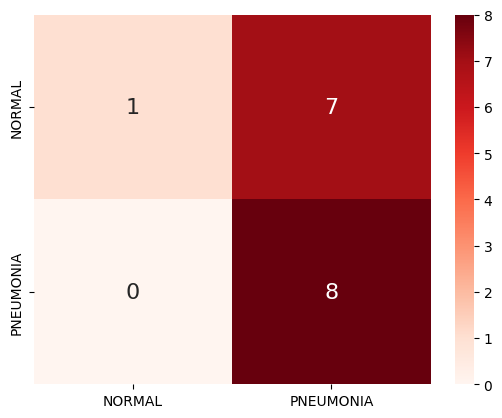

In [108]:
cm = confusion_matrix(y_true, y_pred)
hm = sn.heatmap(cm, annot=True, cmap="Reds", annot_kws={"size": 16}, fmt='d', xticklabels=classification_names, yticklabels=classification_names)

In [109]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.12      0.22         8
         1.0       0.53      1.00      0.70         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16



## Fine-tune ResNet50V2

In [110]:
for layer in base_model.layers[:177]:
    layer.trainable = False
for layer in base_model.layers[177:]:
    layer.trainable = True
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [111]:
model.compile(optimizer=Adam(learning_rate=1e-5),
                loss='binary_crossentropy',
                metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 rescaling (Rescaling)       (None, 7, 7, 2048)        0         
                                                                 
 random_rotation (RandomRota  (None, 7, 7, 2048)       0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 7, 7, 2048)        0         
                                                                 
 re_lu (ReLU)                (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                 

In [112]:

F_history = model.fit(train_dataset,
                    steps_per_epoch = len(train_dataset),
                    epochs=30,
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset))


Epoch 1/30


c:\Users\jamua\.conda\envs\pneumonia-classification\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/random_rotation/loop_body/GatherV2/pfor/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/random_rotation/loop_body/GatherV2/pfor/Reshape:0", shape=(None, 7, 7, 2048), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/random_rotation/loop_body/GatherV2/pfor/Cast:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


261/261 [==============================] - 188s 703ms/step - loss: 0.7974 - accuracy: 0.7289 - val_loss: 1.0528 - val_accuracy: 0.6250
Epoch 2/30
261/261 [==============================] - 191s 731ms/step - loss: 0.7579 - accuracy: 0.7291 - val_loss: 0.9884 - val_accuracy: 0.6250
Epoch 3/30
261/261 [==============================] - 190s 728ms/step - loss: 0.7168 - accuracy: 0.7301 - val_loss: 0.9328 - val_accuracy: 0.6250
Epoch 4/30
261/261 [==============================] - 193s 739ms/step - loss: 0.6852 - accuracy: 0.7260 - val_loss: 0.8844 - val_accuracy: 0.6250
Epoch 5/30
261/261 [==============================] - 190s 728ms/step - loss: 0.6524 - accuracy: 0.7329 - val_loss: 0.8398 - val_accuracy: 0.6250
Epoch 6/30
261/261 [==============================] - 193s 739ms/step - loss: 0.6212 - accuracy: 0.7350 - val_loss: 0.7944 - val_accuracy: 0.6250
Epoch 7/30
261/261 [==============================] - 191s 729ms/step - loss: 0.5876 - accuracy: 0.7421 - val_loss: 0.7498 - val_accura

In [113]:
model.save("finetune_model.h5")

<Figure size 640x480 with 0 Axes>

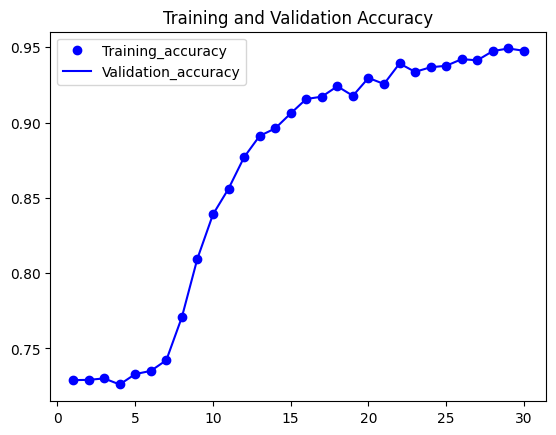

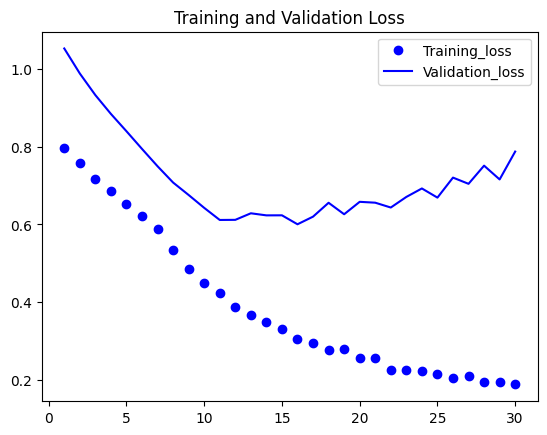

<Figure size 640x480 with 0 Axes>

In [114]:
acc=F_history.history['accuracy']
val_acc=F_history.history['val_accuracy']
loss=F_history.history['loss']
val_loss=F_history.history['val_loss']

epochs=range(1,len(acc) +1)

plt.plot(epochs , acc ,'bo' ,label='Training_accuracy')
plt.plot(epochs , acc ,'b' ,label='Validation_accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs ,loss ,'bo' ,label='Training_loss')
plt.plot(epochs , val_loss ,'b',label='Validation_loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

## Data Augmentation

In [115]:
pred = model.predict(validation_dataset)
pred

1/1 [==============================] - 1s 1s/step


array([[0.5434747 ],
       [0.10726441],
       [0.11618636],
       [0.9831643 ],
       [0.05807202],
       [0.82915795],
       [0.9793768 ],
       [0.97966284],
       [0.97728044],
       [0.58641845],
       [0.9679017 ],
       [0.97932744],
       [0.07920657],
       [0.97963375],
       [0.22080106],
       [0.98221695]], dtype=float32)

In [116]:
predicted_probs = np.empty([1,1])
y_true =  np.empty([1,1])
for images, labels in tqdm(validation_dataset):
    predicted_probs = np.concatenate((predicted_probs, model(images)))
    y_true = np.concatenate([y_true, labels.numpy()])
predicted_probs = np.delete(predicted_probs, [0])
y_true = np.delete(y_true, [0])
y_pred = [1 * (x>=0.5) for x in predicted_probs]

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


In [117]:
# y_true = test_generator.classes
# y_true

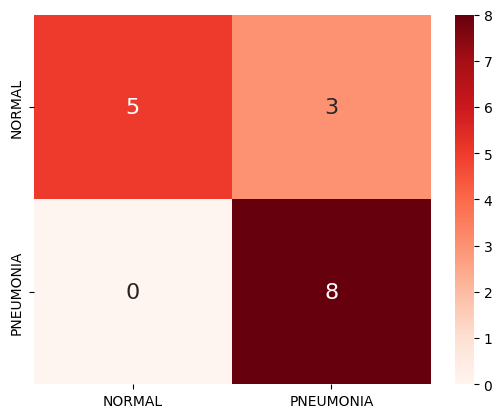

In [118]:
cm = confusion_matrix(y_true, y_pred)
hm = sn.heatmap(cm, annot=True, cmap="Reds", annot_kws={"size": 16}, fmt='d', xticklabels=classification_names, yticklabels=classification_names)

In [119]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.62      0.77         8
         1.0       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16

